In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import random

In [2]:
file_names = ["hollins.dat", "ex1.dat", "ex2.dat"]
file = open(file_names[0], "r")
first_line = file.readline().strip().split(" ")
n_pages = int(first_line[0])
n_links = int(first_line[1])
print(f"Number of pages -> {n_pages}")
print(f"Number of links -> {n_links}")

Number of pages -> 6012
Number of links -> 23875


In [3]:
# storing page links

i = 0
page_names = []
for row in file:
    row = row.strip().split(" ")[1]
    page_names.append(row)
    if i >= n_pages-1:
        break
    i = i+1
print(f"Size page_names -> {len(page_names)}")
print(f"Page 1 -> {page_names[0]}")

Size page_names -> 6012
Page 1 -> http://www1.hollins.edu/


In [4]:
# matrix A

A = np.zeros((n_pages, n_pages), dtype=float)
for row in file:
    row = row.strip().split(" ")
    p1 = int(row[0])
    p2 = int(row[1])
    A[p2-1, p1-1] = 1
file.close()

print(f"Shape A -> {A.shape}")
print(f"Sum of ones in A = {np.sum(A)} should be equal to n_links = {n_links}")
print(f"nan values -> {np.sum(np.isnan(A))}")

Shape A -> (6012, 6012)
Sum of ones in A = 23875.0 should be equal to n_links = 23875
nan values -> 0


In [5]:
# Each columns should sum to 1
# As long there are dangling nodes, I have to make them vote equally for every other page

print("Number of dangling nodes before -> ", (np.sum(A, axis=0) == 0).sum())

mask = np.sum(A, axis=0) == 0
A[:, mask] = 1
A = A * (np.ones(A.shape, dtype=float)-np.eye(A.shape[0]))

# finally I can normalize the matrix
A = A/np.sum(A, axis = 0)
print("Number of dangling nodes now -> ", (np.sum(A, axis=0) == 0).sum())

Number of dangling nodes before ->  3189
Number of dangling nodes now ->  0


In [6]:
print(np.sum(A, axis = 0))

[1. 1. 1. ... 1. 1. 1.]


In [7]:
print(f"Final A.shape -> {A.shape}")
no_outgoing = A.shape[0]-np.count_nonzero(np.sum(A, axis = 0))
print(f"Number of pages with NO outgoing links -> {no_outgoing}")
if (no_outgoing==0):
    print("The matrix is columns-stochastic!")
else:
    print("The matrix isn't columns-stochastic yet, revise your code")

Final A.shape -> (6012, 6012)
Number of pages with NO outgoing links -> 0
The matrix is columns-stochastic!


In [8]:
# Building matrix M, as there might be more than one subwebs
S = np.ones(A.shape, dtype=float)/A.shape[0]
# m is arbitrary, but I am trying first with m = 0.15 (default)
m = 0.15
M = (1-m)*A + m*S
M = M/np.sum(M, axis = 0)
# M is column-stochastic for definition too
print(f"Shape M -> {M.shape}")
# print(np.sum(M, axis=0))
# print(np.abs((np.sum(M, axis =0)-1) < 0.000001).sum())

Shape M -> (6012, 6012)


In [9]:
# find the highest ranked page
# cannot compute finding avery eigenvalue and eigenvector beacuse the matrix is way too big
# I have to apply the power method

def power_method(A):
    # Find the largest eigenvalue and the corresponding eigenvector
    max_iterations=1000
    tolerance=1e-7
    n = A.shape[0]
    x = np.random.rand(n)
    x = x / np.linalg.norm(x) # normalization of x

    eigenvalue_old = np.inf
    
    for i in range(max_iterations):
        # Multiply by A
        y = A @ x
        # Estimate eigenvalue (Rayleigh quotient)
        eigenvalue = x @ y
        # Normalize the vector
        x_new = y/np.linalg.norm(y)
        # Check for convergence
        if np.abs(eigenvalue - eigenvalue_old) < tolerance:
            break
        x = x_new
        eigenvalue_old = eigenvalue
    
    return eigenvalue, x, i

In [10]:
# Alternative implementation with eigenvalue calculation
def my_power_method(A, m):
    n = A.shape[0]
    # Initialize
    x = np.random.rand(n)
    x = x / np.sum(x)
    s = np.full(n, 1/n)
    max_iterations = 1000
    tolerance = 1e-5

    for i in range(max_iterations):
        x_old = x.copy()
        # PageRank iteration
        x = (1 - m )* (A @ x) + m * s
        lambda_est = (x_old @ x) / (x @ x)
        x = x / np.sum(x)
        # check for convergence
        if np.linalg.norm(x - x_old, 1) < tolerance:
            break
    
    return lambda_est, x, i

In [11]:
# max_eigenvalue, eigenspace_basis, n_iterations = power_method(M) # faster
max_eigenvalue, eigenspace_basis, n_iterations = my_power_method(A, m)
tol = 1e-5
print(max_eigenvalue)
if np.abs(max_eigenvalue-1)< tol:
    print(f"Power method converged correctly in {n_iterations} iterations")
else:
    print(f"Power method did not fully converged in {n_iterations} iterations")

# I find the normalized eigenspace basis
normalized = eigenspace_basis/np.sum(eigenspace_basis)

1.0000043112739059
Power method converged correctly in 45 iterations


In [ ]:
# Then I find the score of the highest ranked page
highest_ranked_page = np.argmax(normalized)
print(f"Highest ranked page is {page_names[highest_ranked_page]} -> {np.max(normalized):.6f}")

# I want to show the ranking for top_n_pages pages
top_n_pages = 10
top_n_pages = min(10, n_pages)
print(f"\nIf I want to see the top {top_n_pages} highest ranked pages:")
top_indices = np.argsort(-normalized)
for i in range(top_n_pages):
    print(f"{i+1} ({normalized[top_indices[i]]:.6f} points). {top_indices[i]+1} -> {page_names[top_indices[i]]}")

Highest ranked page is 2 -> 0.019880

If I want to see the top 10 highest ranked pages:
1 (0.019880 points). 2 -> http://www.hollins.edu/
2 (0.009288 points). 37 -> http://www.hollins.edu/admissions/visit/visit.htm
3 (0.008611 points). 38 -> http://www.hollins.edu/about/about_tour.htm
4 (0.008066 points). 61 -> http://www.hollins.edu/htdig/index.html
5 (0.008027 points). 52 -> http://www.hollins.edu/admissions/info-request/info-request.cfm
6 (0.007165 points). 43 -> http://www.hollins.edu/admissions/apply/apply.htm
7 (0.006583 points). 425 -> http://www.hollins.edu/academics/library/resources/web_linx.htm
8 (0.005990 points). 27 -> http://www.hollins.edu/admissions/admissions.htm
9 (0.005572 points). 28 -> http://www.hollins.edu/academics/academics.htm
10 (0.004452 points). 4023 -> http://www1.hollins.edu/faculty/saloweyca/clas%20395/Sculpture/sld001.htm


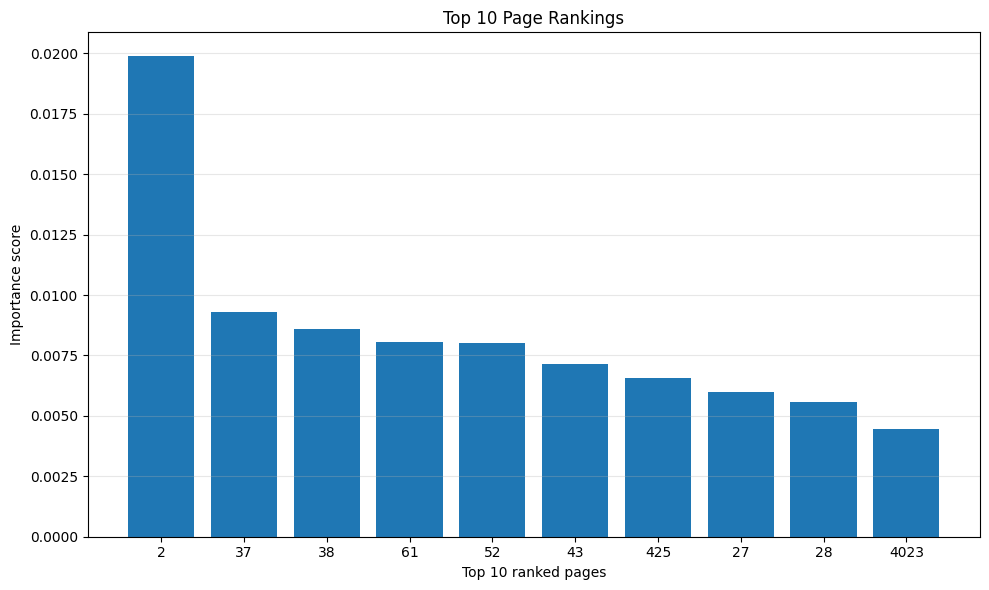

In [13]:
import matplotlib.pyplot as plt

x = np.arange(1, top_n_pages+1)
my_list = []
for i in range(top_n_pages):
    my_list.append(str(top_indices[i]+1))
sorted = np.sort(-normalized)
plt.figure(figsize=(10, 6))
plt.bar(my_list, -sorted[:top_n_pages])  # Use bar plot for ranked data
plt.xlabel(f"Top {top_n_pages} ranked pages")
plt.ylabel("Importance score")
plt.title(f"Top {top_n_pages} Page Rankings")
# plt.xticks(x)  # Show all x-ticks for clarity
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()